In [2]:
import tensorflow as tf
from datetime import datetime
##单层的建立


## 练习一下矩阵乘法的不同形式。
class Dence2(tf.Module):
    def __init__(self,in_features,out_features,name=None):
        super().__init__(name=name)
        self.w=tf.Variable([[-3.14],[-2.31],[2.16]],name='w') ##3行*1列矩阵，name不是必要的
        self.b=tf.Variable(tf.zeros([out_features]),name='b')
    def __call__(self,x):
        y=tf.matmul(x,self.w)+self.b##矩阵乘法
        return tf.nn.sigmoid(y)
nn=Dence2(tf.constant(3),tf.constant(1),'pp')##内层与外层的个数，名字没有意义

nn([[0.0288,-0.3256,0.5925]])##1*3

## 两层连接
class Dence3(tf.Module):
    def __init__(self,in_features,out_features,name=None):
        super().__init__(name=name)
        self.w=tf.Variable(tf.random.normal([in_features,out_features]),name='w') ##3行*1列矩阵，name不是必要的
        self.b=tf.Variable(tf.zeros([out_features]),name='b')
    def __call__(self,x):
        y=tf.matmul(x,self.w)+self.b##矩阵乘法
        return tf.nn.sigmoid(y)

class superdence(tf.Module):        ##两层全连接建立
    def __init__(self,name=None):
        super().__init__(name=name)
        ##bulid two dence
        self.dence_1=Dence3(tf.constant(3),tf.constant(3))
        self.dence_2=Dence3(tf.constant(3),tf.constant(2))
    def __call__(self,x):
        x=self.dence_1(x)
        return self.dence_2(x)
    
kk=superdence(name='sp')

print(kk([[0.0288,-0.3256,0.5925]]))##1*3

tf.Tensor([[0.52295434 0.3842236 ]], shape=(1, 2), dtype=float32)


In [9]:
#打印

class Dence(tf.Module):
    def __init__(self,in_features,out_features,name=None):
        super().__init__(name=name)
        self.w=tf.Variable([[-3.14,-2.31,2.16]],name='w') ##1*3矩阵
        self.b=tf.Variable(tf.zeros([out_features]),name='b')
    def __call__(self,x):
        y=tf.matmul(self.w,x)+self.b
        return tf.nn.sigmoid(y)

mm=Dence(tf.constant(3),tf.constant(1),'mm')##内层与外层的个数。


chkp_path = "my_checkpoint"     ## 确定路径与名字，省略默认在文件附近
checkpoint = tf.train.Checkpoint(model=mm)  ##决定储存哪一个文件
checkpoint.write(chkp_path)  ##将数据写进去
mm([[0.0288],[-0.3256],[0.5925]])##3行*1列

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8745173]], dtype=float32)>

In [8]:
tf.train.list_variables(chkp_path) #输出模型大概形象

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/b/.ATTRIBUTES/VARIABLE_VALUE', [1]),
 ('model/w/.ATTRIBUTES/VARIABLE_VALUE', [1, 3])]

In [12]:
## 层的恢复
new_model = Dence(1,1)##随便赋值
new_checkpoint = tf.train.Checkpoint(model=new_model)
new_checkpoint.restore("my_checkpoint")
new_model([[0.0288],[-0.3256],[0.5925]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8745173]], dtype=float32)>

In [38]:
#层的输出

class smdense(tf.Module):        ##两层全连接建立
    def __init__(self,name=None):
        super().__init__(name=name)
        ##bulid two dence
        self.dence_1=Dence3(tf.constant(3),tf.constant(3))
        self.dence_2=Dence3(tf.constant(3),tf.constant(2))
    @tf.function
    def __call__(self,x):
        x=self.dence_1(x)
        return tf.reduce_sum(self.dence_2(x))
my_model = smdense(name="the_model")
print(my_model([[2.0, 2.0, 2.0]]))
print(my_model([[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0]]]))

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/func/%s" % stamp
writer = tf.summary.create_file_writer(logdir)

# Create a new model to get a fresh trace
# Otherwise the summary will not see the graph.
new_model = smdense()

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = print(new_model(tf.constant([[2.0, 2.0, 2.0]])))
with writer.as_default():
    tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

tf.Tensor(0.9370144, shape=(), dtype=float32)
tf.Tensor(1.8740288, shape=(), dtype=float32)
tf.Tensor(1.3319066, shape=(), dtype=float32)


In [20]:
%tensorboard --logdir logs/func#将图输出出来

Reusing TensorBoard on port 6006 (pid 11536), started 0:00:52 ago. (Use '!kill 11536' to kill it.)

In [42]:
tf.saved_model.save(my_model, "bdmi_model")  ##保存目录

INFO:tensorflow:Assets written to: bdmi_model\assets


In [43]:
new_model = tf.saved_model.load("bdmi_model")##读取整个模型

In [44]:
print(my_model([[3.0, 3.0, 3.0]]))#直接可以使用my_model


tf.Tensor(0.96850383, shape=(), dtype=float32)


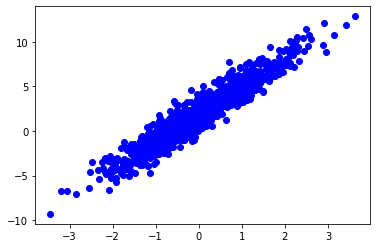

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


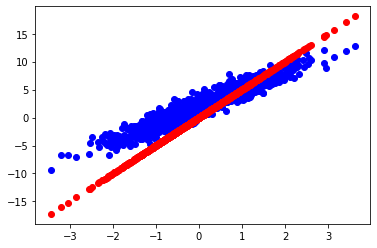

Current loss: 8.931422
Starting: W=5.00 b=0.00, loss=8.93142
Epoch  0: W=4.59 b=0.39, loss=6.04000
Epoch  1: W=4.26 b=0.71, loss=4.20850
Epoch  2: W=4.01 b=0.96, loss=3.04823
Epoch  3: W=3.80 b=1.16, loss=2.31311
Epoch  4: W=3.64 b=1.32, loss=1.84729
Epoch  5: W=3.52 b=1.45, loss=1.55208
Epoch  6: W=3.41 b=1.55, loss=1.36498
Epoch  7: W=3.33 b=1.63, loss=1.24637
Epoch  8: W=3.27 b=1.70, loss=1.17118
Epoch  9: W=3.22 b=1.75, loss=1.12351


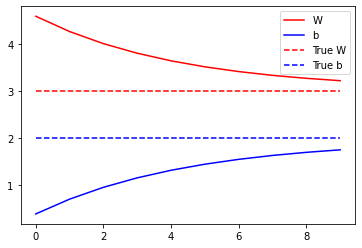

In [49]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = x * TRUE_W + TRUE_B + noise
class myModule(tf.Module):
    def __init__(self,in_features,out_features,name=None):
        super().__init__(name=name)
        self.w=tf.Variable(3.0) 
        self.b=tf.Variable(5.0)
    def __call__(self,x):
        y=x*self.w+self.b##矩阵乘法
        return y
nn=Dence2(tf.constant(3),tf.constant(1),'pp')
# Plot all the data
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)
model = MyModel()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)

# Define a training loop
def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" %
          (epoch, Ws[-1], bs[-1], current_loss))
print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" %
      (model.w, model.b, loss(y, model(x))))

# Do the training
training_loop(model, x, y)

# Plot it
plt.plot(epochs, Ws, "r",
         epochs, bs, "b")

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_B] * len(epochs), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()
